In [1]:
import numpy as np
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


In [4]:
BATCH_SIZE = 32
IMG_SIZE = 224

TRAIN_PATH =   '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
VAL_PATH  = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
TEST_PATH  = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


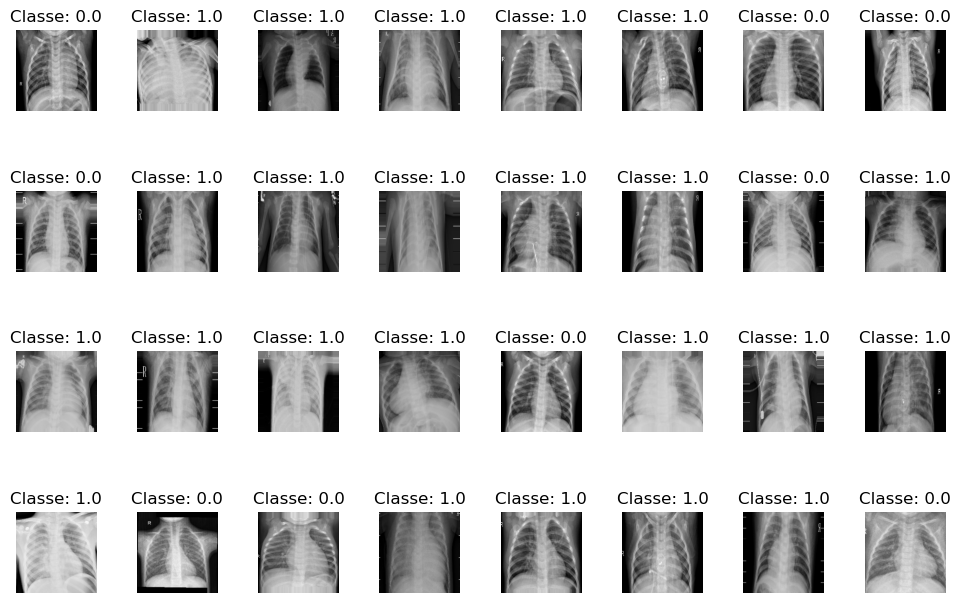

In [5]:
import matplotlib.pyplot as plt

# Obter uma amostra de imagens do gerador de treinamento
images, labels = next(train_generator)

# Exibir as imagens
fig, axes = plt.subplots(4, 8, figsize=(12, 8))
axes = axes.ravel()

for i in range(32):
    axes[i].imshow(images[i])
    axes[i].axis('off')
    axes[i].set_title("Classe: {}".format(labels[i]))
    plt.subplots_adjust(wspace=0.5)

plt.show()


In [8]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)


29084464/29084464 [==============================] - 1s 0us/step


In [16]:
model.compile(optimizer=Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
check_point = ModelCheckpoint('best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=25,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    callbacks=[early_stop, check_point],
                    verbose=1,
                    shuffle=True)


Epoch 1/25
163/163 [==============================] - 221s 950ms/step - loss: 0.2366 - accuracy: 0.9220 - val_loss: 1.6261 - val_accuracy: 0.6250
Epoch 2/25
163/163 [==============================] - 122s 748ms/step - loss: 0.1228 - accuracy: 0.9559 - val_loss: 0.5104 - val_accuracy: 0.8125
Epoch 3/25
163/163 [==============================] - 121s 741ms/step - loss: 0.1046 - accuracy: 0.9615 - val_loss: 2.3824 - val_accuracy: 0.5625
Epoch 4/25
163/163 [==============================] - 122s 745ms/step - loss: 0.1025 - accuracy: 0.9655 - val_loss: 2.2455 - val_accuracy: 0.5000
Epoch 5/25
163/163 [==============================] - 122s 745ms/step - loss: 0.0802 - accuracy: 0.9711 - val_loss: 0.4153 - val_accuracy: 0.8750
Epoch 6/25
163/163 [==============================] - 124s 757ms/step - loss: 0.0810 - accuracy: 0.9699 - val_loss: 0.3099 - val_accuracy: 0.8750
Epoch 7/25
163/163 [==============================] - 122s 746ms/step - loss: 0.0771 - accuracy: 0.9720 - val_loss: 0.2761 -

In [17]:
model.load_weights('best_model.hdf5')

test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


20/20 [==============================] - 11s 498ms/step - loss: 0.2647 - accuracy: 0.9071
Test loss: 0.2647036910057068
Test accuracy: 0.9070512652397156


20/20 [==============================] - 9s 320ms/step


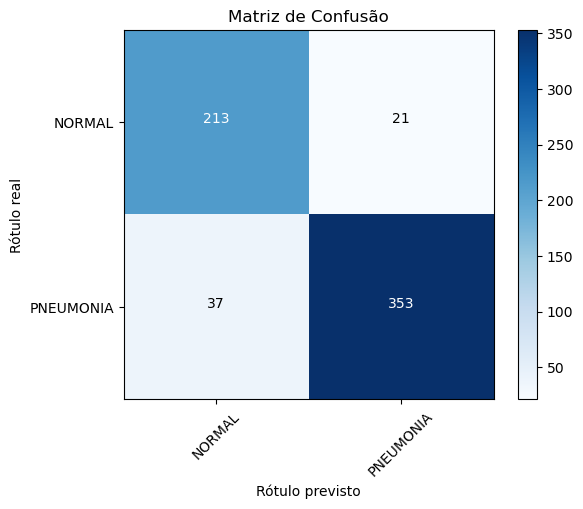

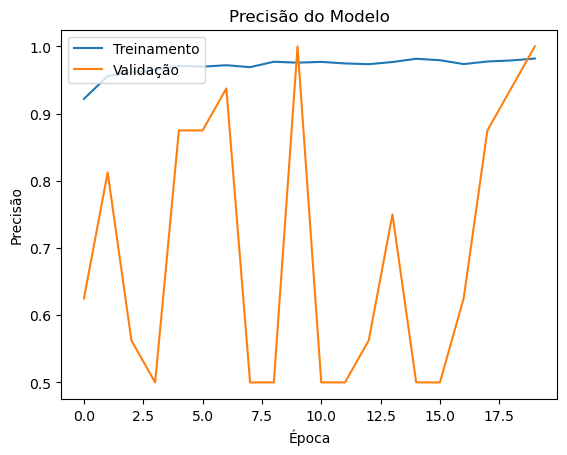

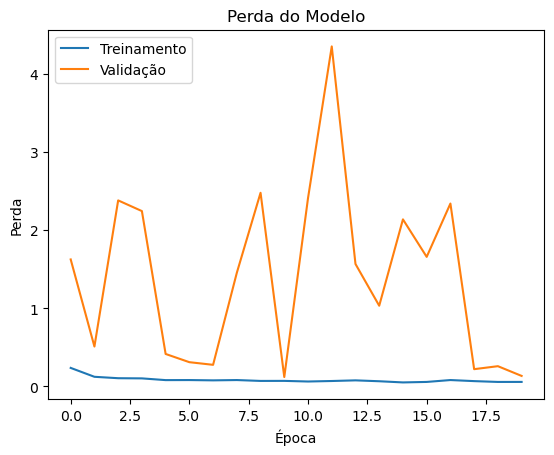

In [18]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

# Plotar a matriz de confusão
predictions = model.predict(test_generator)
y_pred = np.where(predictions > 0.5, 1, 0)
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Mostrar todos os rótulos
classes = list(test_generator.class_indices.keys())
tick_marks = np.arange(len(classes))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(classes, rotation=45)
ax.set_yticklabels(classes)

# Limiar para as cores do texto
thresh = cm.max() / 2.

# Adicionar as anotações de texto
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

ax.set_ylabel('Rótulo real')
ax.set_xlabel('Rótulo previsto')
ax.set_title('Matriz de Confusão')

# Plotar a precisão do modelo de treinamento e validação
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_title('Precisão do Modelo')
ax.set_ylabel('Precisão')
ax.set_xlabel('Época')
ax.legend(['Treinamento', 'Validação'], loc='upper left')

# Plotar a perda do modelo de treinamento e validação
fig, ax = plt.subplots()
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Perda do Modelo')
ax.set_ylabel('Perda')
ax.set_xlabel('Época')
ax.legend(['Treinamento', 'Validação'], loc='upper left')

plt.show()


In [19]:
# Importar bibliotecas
from sklearn.metrics import precision_score, recall_score, f1_score

# Fazer previsões no conjunto de teste
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)  # Convertendo probabilidades em classes binárias (0 ou 1)

# Calcular as métricas
precision = precision_score(test_generator.classes, y_pred)
recall = recall_score(test_generator.classes, y_pred)
f1score = f1_score(test_generator.classes, y_pred)

# Imprimir as métricas
print('Precisão (Precision): {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1-score: {:.4f}'.format(f1score))


20/20 [==============================] - 7s 324ms/step
Precisão (Precision): 0.9439
Recall: 0.9051
F1-score: 0.9241


In [20]:
model.save('modelo_densenet121_Last.h5')